In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
from os import listdir
from os.path import isfile, join
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import multiprocessing

In [2]:
mypath = '../../data/MLgSA/wss/'
mypath1 = '../../data/MLgSA/New_wss/'

onlyfiles = np.asarray([f for f in listdir(mypath) if isfile(join(mypath, f))])
onlyfiles1 = np.asarray([f for f in listdir(mypath1) if isfile(join(mypath1, f))])

onlyfiles.sort()
onlyfiles1.sort()

print(len(onlyfiles), len(onlyfiles1))

short_list = np.asarray([s[5:23] if s[19] == 'l' else s[5:24] for s in onlyfiles])
short_list1 = np.asarray([s[5:23] if s[19] == 'l' else s[5:24] for s in onlyfiles1])
# short_list = np.asarray([s[5:23] if s[19] == 'l' else s[5:24] for s in onlyfiles])

109 50


In [3]:
df = pd.read_csv("../../data/MLgSA/stenosis_metadata.csv", sep=';')
# Matching the stenosis degree to the datasets
# missing datasets : index = [68, 87]
df = df.drop(index=[68, 87])
degree_list = df['ID'].values

In [4]:
meshes = []

for f in onlyfiles:
    reader = pv.get_reader(mypath + f)
    meshes.append(reader.read())
    
for f in onlyfiles1:
    reader = pv.get_reader(mypath1 + f)
    meshes.append(reader.read())

In [5]:
i = 0
for t, (a,b) in enumerate(zip(degree_list, short_list)):
    if a != b:
        i = t
        print(i)
        print(degree_list[i], short_list[i])
        print(degree_list[i] in short_list)
        break

In [6]:
# data stats
dl = []

for mesh in meshes:
    dl.append(np.asarray(mesh.point_data.values()[1]))

data = np.concatenate(dl)
mins = np.min(data)
maxs = np.max(data)
print(mins, maxs, maxs - mins)

1.5448250238086984e-06 1674.871828135934 1674.871826591109


In [8]:
def get_graph(mesh):
    node_array = mesh.points
    n = node_array.shape[0]
    rows = []
    cols = []
    
    features = (np.asarray(mesh.point_data['non-directional_WSS_@_t=1.1']).T - mins)/(maxs - mins)

    for i in range(mesh.number_of_cells):
        cell = mesh.get_cell(i)
        cell_points = cell.point_ids
        n_points = len(cell_points)
        for j in range(n_points):
            for k in range(j + 1, n_points):
                p1 = cell_points[j]
                p2 = cell_points[k]
                rows.append(p1)
                cols.append(p2)
                rows.append(p2)
                cols.append(p1)  


    adj_matrix_coo = coo_matrix((np.ones(len(rows)), (rows, cols)), shape=(mesh.number_of_points, mesh.number_of_points))
    edges = list(zip(adj_matrix_coo.row, adj_matrix_coo.col))
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    
    return edge_index, n, torch.tensor(features, dtype=torch.float32).view((-1,1)), torch.tensor(mesh.points, dtype=torch.float32)

In [10]:
edjl = []
numl = []
nf = []
pos = []

p = multiprocessing.Pool(8)

for j, m in enumerate(meshes):
    edj, num, fe, po = get_graph(m)
    edjl.append(edj)
    numl.append(num)
    nf.append(fe)
    pos.append(po)

p.close()
p.join()


In [11]:
torch.save(edjl, '../../data/MLgSA/edge_indices.pt')
torch.save(numl, '../../data/MLgSA/nodes.pt')
torch.save(nf, '../../data/MLgSA/node_features.pt')
torch.save(pos, '../../data/MLgSA/pos.pt')

In [21]:
sten = df['Stenosis Degree'].values
ys = [0 if i<50. else 1 for i in sten]

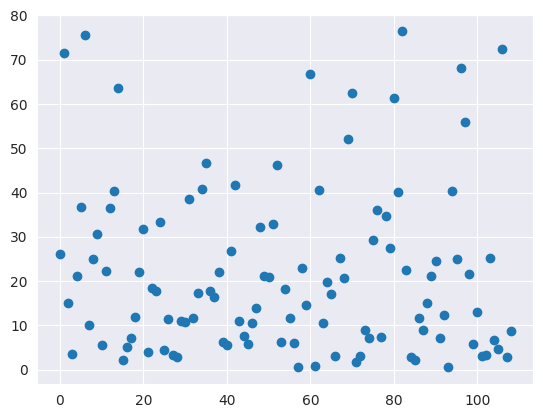

In [20]:
plt.scatter(range(109), sten)

In [25]:
np.count_nonzero(ys)

11

In [27]:
new_ys = ys + [1]*50

print(len(new_ys) == len(meshes))

True


In [28]:
new_ys = torch.tensor(new_ys, dtype=torch.long)

In [29]:
torch.save(new_ys, '../../data/MLgSA/classes.pt')

In [31]:
dataset = [Data(x = a, edge_index=b, y = y, pos=posns) for (a, b, y, posns) in zip(nf, edjl, new_ys, pos)]


In [32]:
torch.save(dataset, '../../data/MLgSA/dataset.pt')

In [33]:
X_train, X_test, y_train, y_test = train_test_split(dataset, new_ys,
                                                    stratify=new_ys,
                                                    test_size=0.25)

In [34]:
torch.save(X_train, '../../data/MLgSA/train_split.pt')
torch.save(X_test, '../../data/MLgSA/test_split.pt')

In [35]:
train_loader = DataLoader(X_train, batch_size=1, shuffle=True)
test_loader = DataLoader(X_test, batch_size=1)

torch.save(train_loader, '../../data/MLgSA/train_loader.pt')
torch.save(test_loader, '../../data/MLgSA/test_loader.pt')